In [1]:
import os, requests, torch, transformers, warnings
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from io import BytesIO
from torchvision.utils import make_grid

ckpt_name = 'aehrc/cxrmate-tf'

device = 'cpu'

encoder_decoder = transformers.AutoModel.from_pretrained(ckpt_name, trust_remote_code=True).to(device)
tokenizer = transformers.PreTrainedTokenizerFast.from_pretrained(ckpt_name)
image_processor = transformers.AutoFeatureExtractor.from_pretrained(ckpt_name)

test_transforms = transforms.Compose(
    [
        transforms.Resize(size=image_processor.size['shortest_edge']),
        transforms.CenterCrop(size=[
            image_processor.size['shortest_edge'],
            image_processor.size['shortest_edge'],
        ]
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std,
        ),
    ]
)

/software/projects/pawsey0864/anicolson/environments/multimodal_23/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


trainable params: 147456 || all params: 80916528 || trainable%: 0.18223223814051934


/software/projects/pawsey0864/anicolson/environments/multimodal_23/lib/python3.10/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [2]:
# Study A:
url = 'https://www.glowm.com/resources/glowm/graphics/figures/atlases/Chest/RMLPNEUMPA_250.jpg'
response = requests.get(url)
image_1 = Image.open(BytesIO(response.content))
image_1 = image_1.convert('RGB')

url = 'https://www.glowm.com/resources/glowm/graphics/figures/atlases/Chest/RMLPNEUMLAT250.jpg'
response = requests.get(url)
image_2 = Image.open(BytesIO(response.content))
image_2 = image_2.convert('RGB')

# Study B:
url = 'https://prod-images-static.radiopaedia.org/images/566180/d527ff6fc1482161c9225345c4ab42_big_gallery.jpg'
response = requests.get(url)
image_3 = Image.open(BytesIO(response.content))
image_3 = image_3.convert('RGB')

image_1 = test_transforms(image_1)
image_2 = test_transforms(image_2)
image_3 = test_transforms(image_3)

study_a = torch.stack([image_1, image_2], dim=0)
study_b = image_3.unsqueeze(0)

images = torch.nn.utils.rnn.pad_sequence([study_a, study_b], batch_first=True, padding_value=0.0)
images.shape

torch.Size([2, 2, 3, 384, 384])

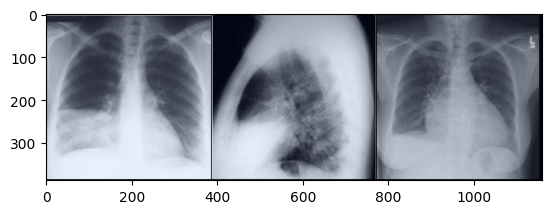

In [3]:
display_images = torch.stack([image_1, image_2, image_3], dim=0)
plt.imshow(make_grid(display_images, normalize=True).permute(1, 2, 0))

In [4]:
previous_findings = [
    'Chest X-ray',
    None,
]
previous_impression = [
    'Chest X-ray',
    None
]

# Tokenize prompt:
prompt = encoder_decoder.tokenize_prompt(
    previous_findings, 
    previous_impression, 
    tokenizer, 
    256, 
    add_bos_token_id=True,
)

In [5]:
prompt

{'input_ids': tensor([[   8, 3254, 9464,   22, 2041,    9, 3254, 9464,   22, 2041,    1],
         [   8,   10,    9,   11,    1,    4,    4,    4,    4,    4,    4]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])}

In [6]:
outputs = encoder_decoder.generate(
    pixel_values=images,
    decoder_input_ids=prompt['input_ids'],
    special_token_ids=[
        tokenizer.additional_special_tokens_ids[
            tokenizer.additional_special_tokens.index('[PMT-SEP]')
        ],
        tokenizer.bos_token_id,
        tokenizer.sep_token_id,
    ],  
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    mask_token_id=tokenizer.pad_token_id,
    return_dict_in_generate=True,
    use_cache=True,
    max_length=256 + prompt['input_ids'].shape[1],
    num_beams=4,
)


In [12]:
outputs.sequences

tensor([[   8, 3254, 9464,   22, 2041,    9, 3254, 9464,   22, 2041,    1,  846,
          148,  369,  680,  132,  115,  250, 1062,  558,  384,  282,  115,  182,
          193,  480,  172, 2449,  132,  115,  182,  428, 1221,   21,  848, 1249,
          132,  182, 1189,  381,  148,  182,  346,  381,  319,   23,  139, 2709,
          132,  115,  342,  150,  303,   23,  139,  375,  148,  356,  349,  150,
          237,   23,  198,  183,  578,  120, 1186,   23,    3, 1097, 1189,  381,
          148,  182,  346,  381,  319,   23, 5726, 2768,  197, 1008,   23,  246,
          636, 1008,   23,  246,  282, 3977,   35, 2843,  318,  505,  246, 1684,
         1478,  848,  725, 1285,   23,    2],
        [   8,   10,    9,   11,    1,    4,    4,    4,    4,    4,    4,  982,
          475,  120,  296,   23, 2596,  492,  350,  660,   23,  213,  120,  163,
          322, 1455,   23,  213,  120,  106,  398,  182,  183,  171,   23,  213,
          120,  163,  211,   23, 2857,  970,  150, 3000,   23, 

In [9]:
# Findings and impression sections (exclude previous impression section):
_, findings, impression = encoder_decoder.split_and_decode_sections(
    outputs.sequences,
    [tokenizer.bos_token_id, tokenizer.sep_token_id, tokenizer.eos_token_id],
    tokenizer
)

In [11]:
for i, j in zip(findings, impression):
    print(f'Findings: {i}\nImpression: {j}\n')

Findings: Frontal and lateral radiographs of the chest demonstrate increased opacity at the right lung base with obscuration of the right heart border, findings suggestive of right middle lobe and right lower lobe pneumonia. The remainder of the lungs are clear. The cardiac and mediastinal contours are normal. No pleural abnormality is detected.
Impression: Right middle lobe and right lower lobe pneumonia. Telephone notification to Dr. ___ by Dr. ___ at 16:30 on ___, ___ min after findings were made.

Findings:  severe cardiomegaly is unchanged. Vascular congestion has improved. There is no focal infiltrate. There is a small right pleural effusion. There is no pneumothorax. Sternal wires are aligned.
Impression: Cardiomegaly with improved vascular congestion

